# 04 - Applied ML

In [1]:
from math import ceil

import seaborn as sns

import pandas as pd
import numpy as np
import scipy.stats as stats
from operator import itemgetter
from scipy.stats import kstest

from scipy.stats import pareto
from scipy.stats import powerlaw
from scipy.stats import rayleigh

from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline

We load the dataframe and then proceed to properly categorize the 'race' observed feature as well as converting the married and nodegree variables to printable names.

In [4]:
df = pd.read_csv('lalonde.csv', index_col=[0])

df['race'] = 'white'
df.loc[df['black'] == 1, 'race'] = 'black'
df.loc[df['hispan'] == 1, 'race'] = 'hispanic'
df.drop('black', 1, inplace=True)
df.drop('hispan', 1, inplace=True)
df['race'] = df['race'].astype('category')

df['married'] = df['married'].replace({0: 'Not married', 1: 'Married'}).astype('category')
df['nodegree'] = df['nodegree'].replace({0: 'Degree', 1: 'No degree'}).astype('category')

# Question 1

For each group, we proceed to represent the data by means of the gaussian kernel density estimate and histograms.

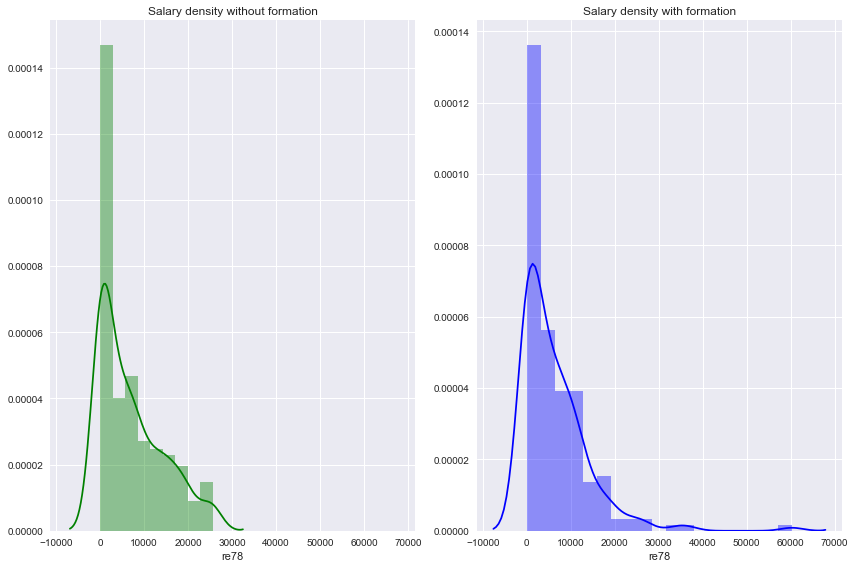

In [5]:
def plot_re78(df):
    treated_res = df[df['treat'] == 1]['re78']
    not_treated_res = df[df['treat'] == 0]['re78']
    f, axes = plt.subplots(1, 2, figsize=(12, 8), sharex=True)
    ax = axes[0]
    ax.set_title("Salary density without formation")
    sns.distplot(not_treated_res, color="g", ax=ax)
    ax = axes[1]
    ax.set_title("Salary density with formation")
    sns.distplot(treated_res, color="b",  ax=ax)
    plt.tight_layout();

plot_re78(df)

The two distribution have a similar shape, this does not give us much information about the effectiveness of the treatment.

We also used a violin plot to have more information. A violin plot is like a boxplot, but is also shows the kernel density estimation on the side.

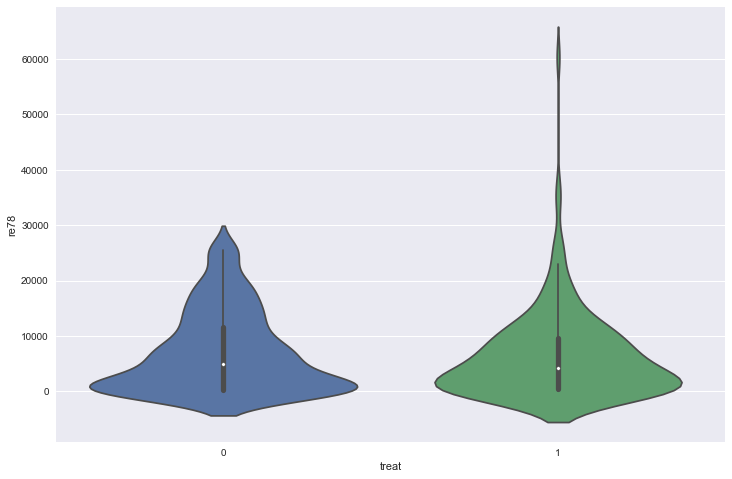

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
sns.violinplot(y='re78',x='treat', data=df, ax=ax);

From these plots, we again see a similar shape in distribution, however, we now see that the median and the interquartile are higher for the not-treated.

Finally, we look at some basic features for each group using pandas "describe".

In [7]:
print("Not treated stats:")
print(df[df['treat'] == 0]['re78'].describe())
print("\nTreated stats:")
print(df[df['treat'] == 1]['re78'].describe())

Not treated stats:
count      429.000000
mean      6984.169742
std       7294.161791
min          0.000000
25%        220.181300
50%       4975.505000
75%      11688.820000
max      25564.670000
Name: re78, dtype: float64

Treated stats:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


We seee that the mean and the median is higher (+600$) for the not-treated.

The naive interpretation suggested by this representation - which assumes that the two groups are comparable and that unobserved variables have no impact on the experiment - is that the treatment, i.e. the formation, has negative impact on the future salary.

The first thing that can be noticed is that the number of samples for the two groups is uneven: 185 samples for the treated group against 429 samples for the controlled group. This raises some doubts about the possibility of applying matched observation study. Furthermore, all the statistical metrics are also very different among the groups which doesn't lead us to believe the two groups are really comparable in terms of observed covariates. We will determine the hypothesis at the next point.

# 2

We will use some plots to see the difference of covariates between treated and not treated.

We use violin plots for the not categorical variables, such as age, education and salaries.

We use simple count for the categorical variables.

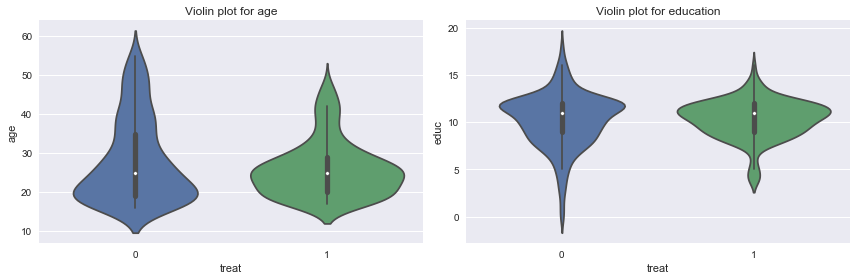

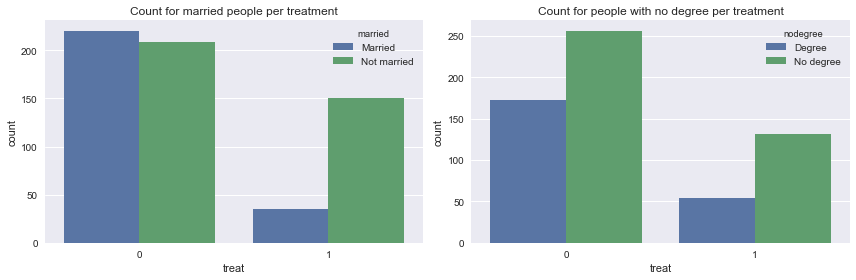

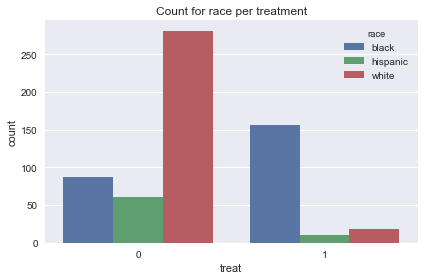

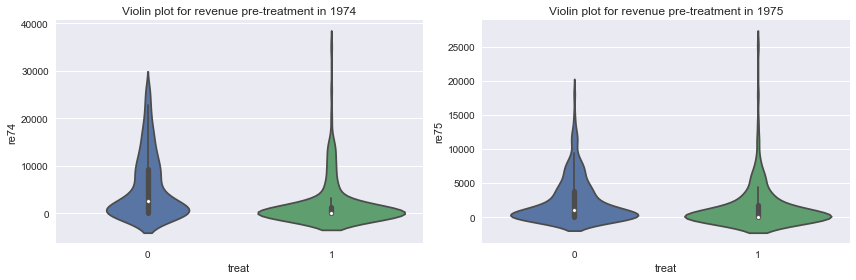

In [8]:
def plot_observed_covariates(df):
    fig, axes = plt.subplots(1,2,figsize=(12,4))

    axes[0].set_title("Violin plot for age")
    sns.violinplot(x='treat', y='age', data=df, ax=axes[0])
    axes[1].set_title("Violin plot for education")
    sns.violinplot(x='treat', y='educ', data=df, ax=axes[1])
    plt.tight_layout()

    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[0].set_title("Count for married people per treatment")
    sns.countplot(x='treat',hue='married', data=df, ax=axes[0])
    axes[1].set_title("Count for people with no degree per treatment")
    sns.countplot(x='treat',hue='nodegree', data=df, ax=axes[1])
    plt.tight_layout()

    fig, axes = plt.subplots(1,1,figsize=(6,4))
    axes.set_title("Count for race per treatment")
    sns.countplot(x='treat',hue='race', data=df, ax=axes)
    plt.tight_layout()

    fig, axes = plt.subplots(1,2,figsize=(12,4))
    axes[0].set_title("Violin plot for revenue pre-treatment in 1974")
    sns.violinplot(x='treat', y='re74', data=df, ax=axes[0])
    axes[1].set_title("Violin plot for revenue pre-treatment in 1975")
    sns.violinplot(x='treat', y='re75', data=df, ax=axes[1])
    plt.tight_layout();

plot_observed_covariates(df)

We observe that all the feature distributions are unbalanced among the two groups. 

In order to make sense of an observational study the distributions of the same covariates among the two groups must be similar. This condition allows to affirm that there are similar matched pairs (x,y) - with x element of the treated group and y element of the controlled group - so that if you don't know their treatment assignment a priori, then you have no way to determine it. In others words x and y must have the same probability of having been treated or not. However in our case the distribution for age, marriage, degree, race and pre-treatement is so different among groupes that it is not possible to make this assumption, therefore the naive interpretation of point 1 is totally invalidated.

# 3

We compute the propensity score using a logistic regression for each covariates.

Since we made some variables categorical, we use pandas to transform them in dummies variables. Then we simply fit our logistic regression and the propensity scores are the probabilities of being in the treatment (i.e. second column).

Then we add a propensity column to a copy of our dataframe and compute a violin plot.

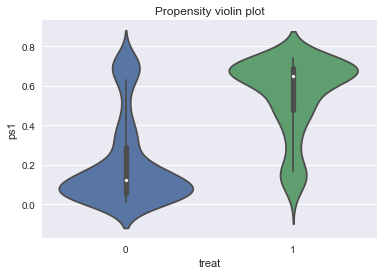

In [25]:
from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression()
def compute_propensity(data):
    x = pd.get_dummies(data, columns=['race', 'married', 'nodegree']).drop(['treat', 're78'], 1)
    y = data['treat']
    logistic.fit(x,y)
    return pd.Series(logistic.predict_proba(x)[:,1], index=data.index)

propensity = compute_propensity(df)
df_copy = df.copy()
df_copy['ps1'] = propensity
sns.violinplot(x='treat', y='ps1', data=df_copy)
plt.title("Propensity violin plot");

This visual representation of the propensity score - which is nothing else than the reduction to a single variable of the information associated to the observed covariates - confirm what was said in the previous point: we see the distribution of the propensity score is so unbalanced that based on it the people in the treated group have an high probability of having been treated while those in the controlled group have a very low probability, while for being able to draw conclusions from the data the two distribution should be indistiguishable.
Please note that in this case the propensity score isn't a measure of the probability of beign treated, since the naive model has already been invalidated.

# 4 

The first approach we try is graph based. The idea is to add an edge between all pairs of nodes (x, y) where x belongs to the treated group and y belongs to the controlled group. The weight of the edge between a pair is the absolute difference of the two nodes' propensity.

Rather than using networkx, we noticed that scipy had a function that did exactly what we wanted, i.e. minimum weight matching in bipartite graph. Let $C$ be the cost matrix, where $C_{i,j}$ is the cost of matching the person $i$ with the person $j$. The cost of matching those two person of different group is the absolute difference of propensity. The rows are the treated persons and the columns the not treated.

We simply loop to add the cost, compute the minimum weight matching, create a matched data frame containing all the persons and print the result of the sum of absolute difference.

In [56]:
from scipy.optimize import linear_sum_assignment

def match(data, propensity, treated_importance=True):
    """Match function take as input a dataframe and 
        a boolean to define on which criteria to keep all values,
        i.e. treated or not treated"""
    group1 = propensity[(data[data['treat'] == int(treated_importance)]).index]
    group2 = propensity[(data[data['treat'] == int(not treated_importance)]).index]
    
    cost = np.zeros((len(group1), len(group2)))
    for i in range(len(group1)):
        for j in range(len(group2)):
            cost[i][j] = np.abs(group1[i]-group2[j])
    row_ind, col_ind = linear_sum_assignment(cost)
    matched = data[data['treat'] == int(treated_importance)].iloc[row_ind]
    return matched.append(data[data['treat'] == int(not treated_importance)].iloc[col_ind])

Let's plot the propencies score per group.

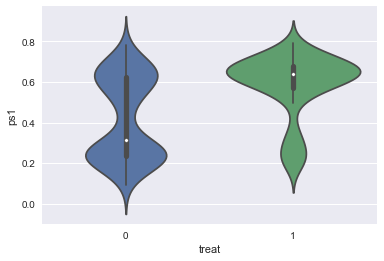

In [57]:
matched = match(df, compute_propensity(df))
propensity = compute_propensity(matched)
matched['ps1'] = propensity
sns.violinplot(x='treat', y='ps1', data=matched);

We can see that the distribution of the propency score among the two groups is still unbalanced, we will try to see why is that when we look at the features.

Let's first get some stats and plot the salary density per group.

Not treated stats:
count      185.000000
mean      5562.450366
std       5850.571807
min          0.000000
25%        116.740400
50%       3892.332000
75%       8154.095000
max      20243.380000
Name: re78, dtype: float64

Treated stats:
count      185.000000
mean      6349.143530
std       7867.402218
min          0.000000
25%        485.229800
50%       4232.309000
75%       9642.999000
max      60307.930000
Name: re78, dtype: float64


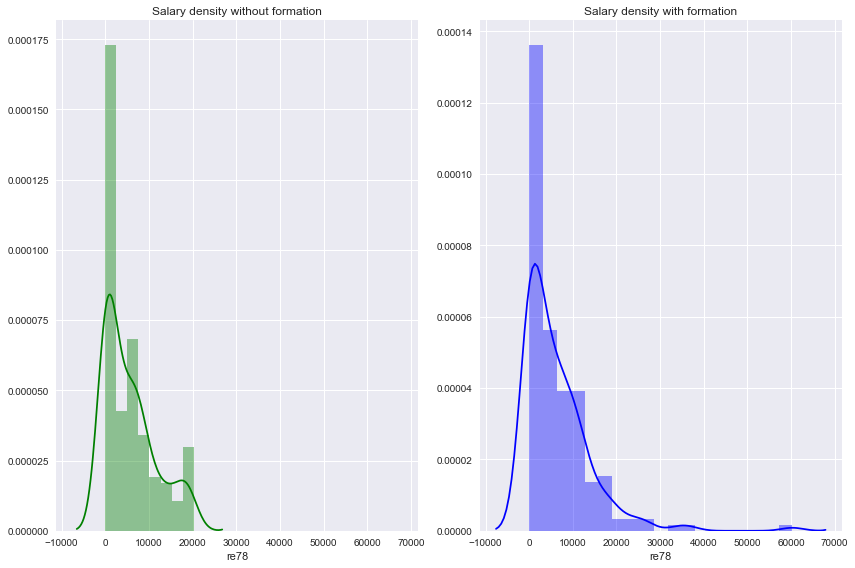

In [58]:
plot_re78(matched)
print("Not treated stats:")
print(matched[matched['treat'] == 0]['re78'].describe())
print("\nTreated stats:")
print(matched[matched['treat'] == 1]['re78'].describe())

These plot are very different from their previous version. We would now conclude that the group that had the formation has now indeed a better average salary.

Let's plot the distribution of the observed covariates to see if the hypothesis of similarity among treated and controlled group is more respected than before.

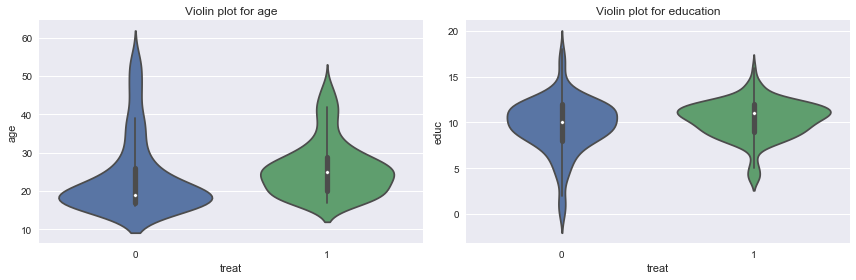

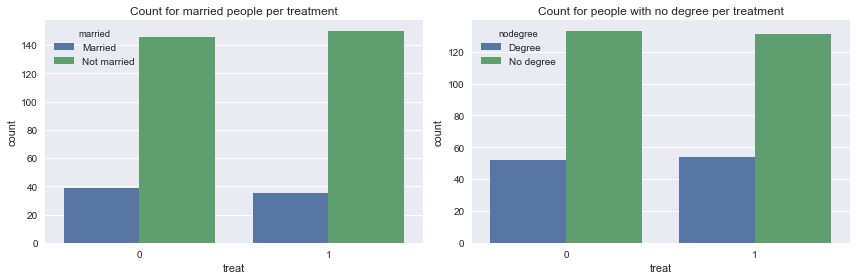

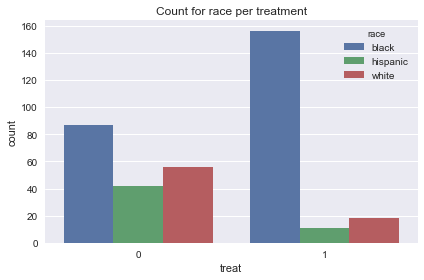

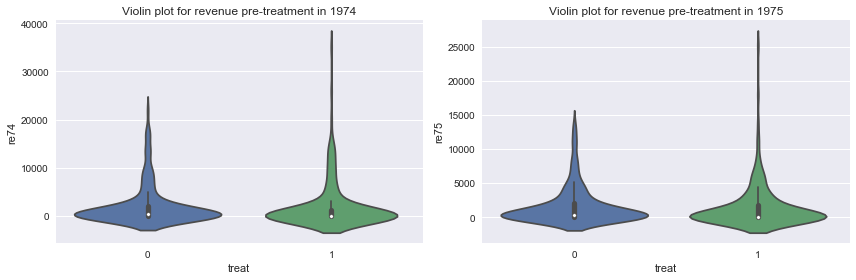

In [59]:
plot_observed_covariates(matched)

We see that indeed the similarity among the two groups has drastically increased. In facte most the feature can be considered as weel balanced, except for the 'race'. We have significantly more black person in the treatment group.

In conclusion, by applying a matching algorithm we're closer to being able to draw conclusion,even if the hypothesis of similarity among groups still isn't perfectly respected.

# 5 

While we think our matching is pretty good as it is, there's still room for improvement. We'll do a refined matching that add constraints related to the most problematic feature, race. What we will do is force every 'black' person to be matched to another 'black' person, even if that means reducing the treated sample.

Practically, what we do is we first do a match between non-black persons, then we do a match between black people, but since there is more black people in the treated than in the not-treated, we will give do the match on all black persons in the not treated group.

In [60]:
propensity = compute_propensity(df)

df_not_black = df[df['race'] != 'black']
matched_not_black = match(df_not_black, propensity)

df_black = df[df['race'] == 'black']
matched_black = match(df_black,propensity, False)

matched = matched_black.append(matched_not_black)

Let's plot again the covariates.

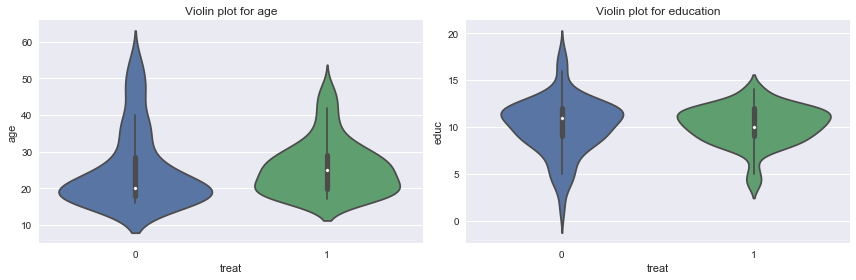

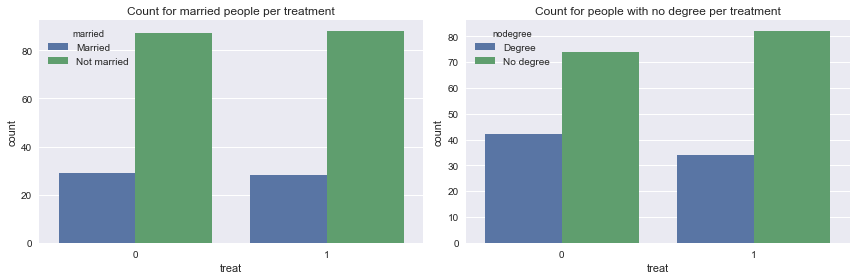

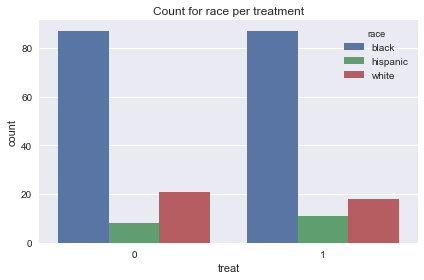

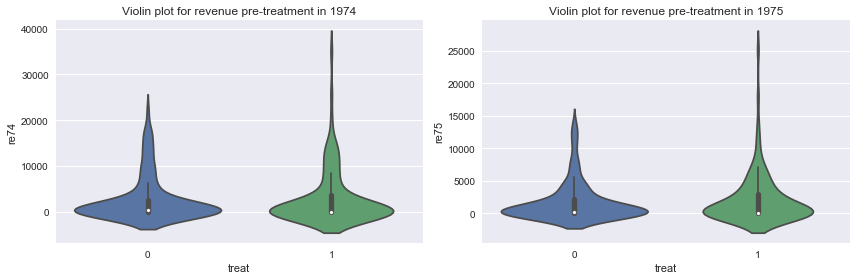

In [62]:
plot_observed_covariates(matched)

The proportion in the race category is now much better and the rest did not change much.

We will again compare the propensity score by plotting a violin plot.

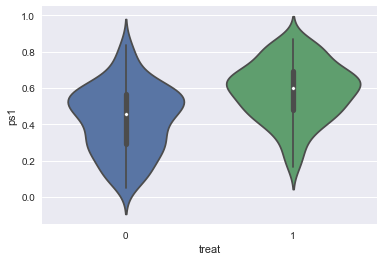

In [46]:
propensity = compute_propensity(matched)
matched['ps1'] = propensity
sns.violinplot(x='treat', y='ps1', data=matched);

We see that now the propensity score between the two categories are a lot better balanced.

# 6 

Not treated stats:
count      116.000000
mean      4918.268981
std       5837.783605
min          0.000000
25%          0.000000
50%       2283.087500
75%       7512.762250
max      20243.380000
Name: re78, dtype: float64

Treated stats:
count      116.000000
mean      6936.833122
std       8235.716573
min          0.000000
25%        725.969275
50%       5336.144500
75%       9940.204750
max      60307.930000
Name: re78, dtype: float64


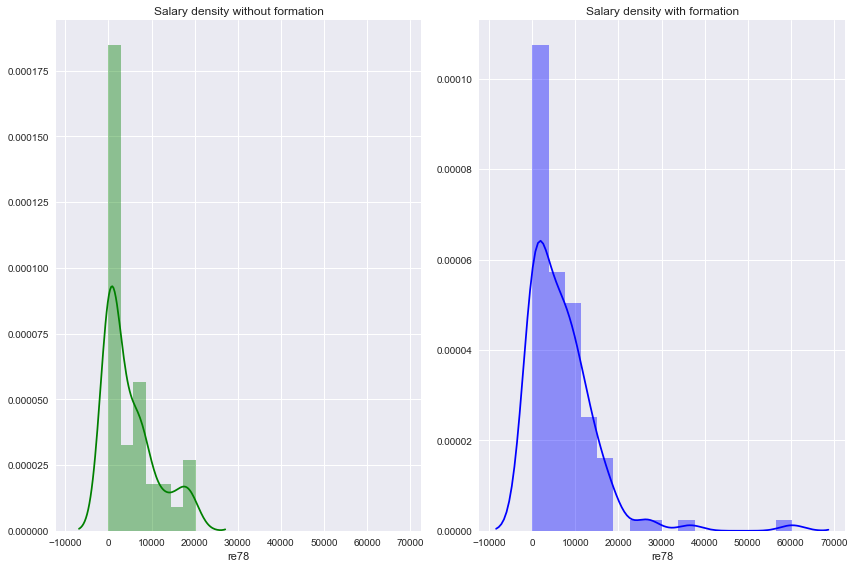

In [63]:
print("Not treated stats:")
print(matched[matched['treat'] == 0]['re78'].describe())
print("\nTreated stats:")
print(matched[matched['treat'] == 1]['re78'].describe())
plot_re78(matched)

Now that we've done the best to balance our observed covariates, we must accept that we're as close as we can to respecting the similarity hypothesis. With this in mind and assuming the unobserved covariates have no influence on the experiment, we can use the naive model to affirm that the formation has a positive impact on the perceived salary of the people who undertake it, since the salary density for these people is centered around much higher values.

# Question 2

## Part 1
First of all we fetch the dataset.

In [2]:
newsgroups = fetch_20newsgroups(subset='all', data_home="./")

We begin by compute the tf-idf for the entire corpus. It will create a matrix of the form "number of posts" x "number of words in the whole corpus". We make use of the stop words included in the scikit-learn to remove them, as they do not give information about a certain post category.

In [358]:
vectorizer = TfidfVectorizer(stop_words='english')
data_tf_idf = vectorizer.fit_transform(newsgroups.data)

Then we partition the dataset in train, validation and test subsets. For the train set set we take the first 10% of the dataset, for the validation set we take the second 10% and for the test test set all that's left. This approach assumes that the dataset stores data in no particular order. If the data were ordered then splitting the data this way wouldn't be acceptable since we'd train the model on a specific category and then test it on another which would lead to poor performance. We printed and analyzed the data contained in newsgroups.data  and could remark that there's no relation of order between an element and the following one in the dataset.

In [359]:
data_size = newsgroups.target.shape[0]
train_size = ceil(data_size/10)
validation_size = train_size
test_size = data_size - train_size - validation_size

x_train = data_tf_idf[:train_size]
y_train = newsgroups.target[:train_size]

x_validation = data_tf_idf[train_size:2*train_size]
y_validation = newsgroups.target[train_size:2*train_size]

x_test = data_tf_idf[2*train_size:]
y_test = newsgroups.target[2*train_size:]

Now we need to train a random forest. First we use the validation test to do a grid search on the "max_depth" and "n_estimators" parameters to determine which values give the best results.

An exhaustive grid search would take a very long time, therefore we don't iterate on continuous subsets but we sample values in the range [1,41] with step 5 for "max_depth" and in the range [1,1001] with step 100 for "n_estimators". We chose large ranges in order to try capturing the behaviour of the parameters.

After the completion of the grid search we initialize a random forest with the parameters which produced best results in the grid search, and then train and test the random forest by using the corresponding sets.

In [390]:
seed = 1
depths = range(1, 42, 5)
n_estimators= range(1, 1002, 100)

best_prediction_score = 0
best_depth = -1
best_n_estimators = -1

for depth in depths:
    for n_estimator in n_estimators:
        clf = RandomForestClassifier(max_depth= None, n_estimators= n_estimator, random_state=seed, n_jobs = -1)
        clf.fit(x_train, y_train)
        predictions_validation = clf.predict(x_validation)
        prediction_score = metrics.accuracy_score(y_validation, predictions_validation)
        if prediction_score > best_prediction_score:
            best_prediction_score = prediction_score
            best_depth = depth
            best_n_estimators = n_estimator
            
print(best_depth, best_n_estimators, best_prediction_score)

1 1001 0.757559681698


In [392]:
clf = RandomForestClassifier(max_depth=None, n_estimators=best_n_estimators, random_state=seed, n_jobs = -1)
clf.fit(x_train, y_train)
predictions = clf.predict(x_test)

print(metrics.accuracy_score(y_test, predictions))

0.769700185726


Finally, we plot the confusion matrix associated to the random forest's predictions.

Please note that in order to compute the accuracy of the predictions and the confusion matrix we use methods of sklearn's metrics module. The manual implementation of these two methods would have been pretty straightforward therefore we think this choice doesn't impact negatively the learning process of the Machine Learning pipeline.

We went passed the actual newsgroup labels to the heatmap to make it more readable.

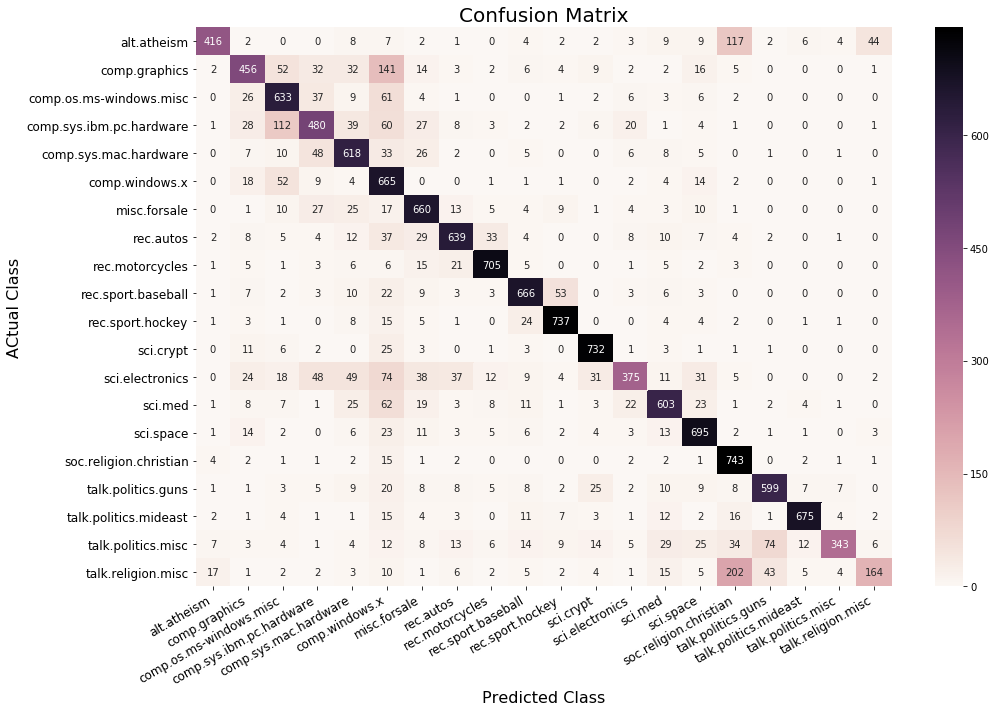

In [393]:
confusion_matrix = metrics.confusion_matrix(y_test, predictions)

fig, ax = plt.subplots(figsize=(15,10))
plt.title("Confusion Matrix", fontsize=20)
sns.heatmap(confusion_matrix, xticklabels=newsgroups.target_names, yticklabels=newsgroups.target_names, ax=ax, annot=True, fmt="d", cmap=sns.cubehelix_palette(dark=0, light=0.97, as_cmap=True))
ax.set_xlabel("Predicted Class", fontsize=16)
ax.set_ylabel("ACtual Class", fontsize=16)
ax.tick_params(labelsize=12)
fig.autofmt_xdate()
plt.tight_layout();

This confusion matrix shows how the the model produces mostly correct predictions, since we have high values on the diagonal and lower values elsewhere.
We can see that there is some confusion amongst posts related to the macro-category "comp", which makes sense.

Also we can see that sci.electronics posts are often confused with some articles of "comp".

Finally, the most significative confusion are the following:
- The posts talking about misc. religion are very often confused for posts about christian religion, which makes sense
- Posts about atheism are often mistaken for posts about christianism, which makes sense, but it is quite a bad confusion, since people wanting to read religious posts may not want to see atheist posts...
- Finally, there is some confusion for misc. political posts with posts about politics and guns, this confusion is not very "bad".


### Word importance analysis
Note that when we speak of feature, we actually speak of words.

We first compute the percentage of features that have a non-zero importance.

In [394]:
num_features = len(clf.feature_importances_)
non_zero =  clf.feature_importances_[clf.feature_importances_ != 0]
print("There is %.2f%% of features that are non-zero"%(len(non_zero)/num_features*100))

There is 20.64% of features that are non-zero


There is around 21% of the features that are non-zero, this means that the rest of the features have no importance to help determining the class of the post.

For example, if a word is only appearing in one post, it will have zero value in all other posts. This criteria will certainly not be selected for a tree decision, since it only helps with a single post. Another possibility would be to have a word that appears in every post with a similar tf-idf, this word would not help us choose a category, thus it will certainly not be selected by the algorithm.

We begin by plotting the raw importances of feature.

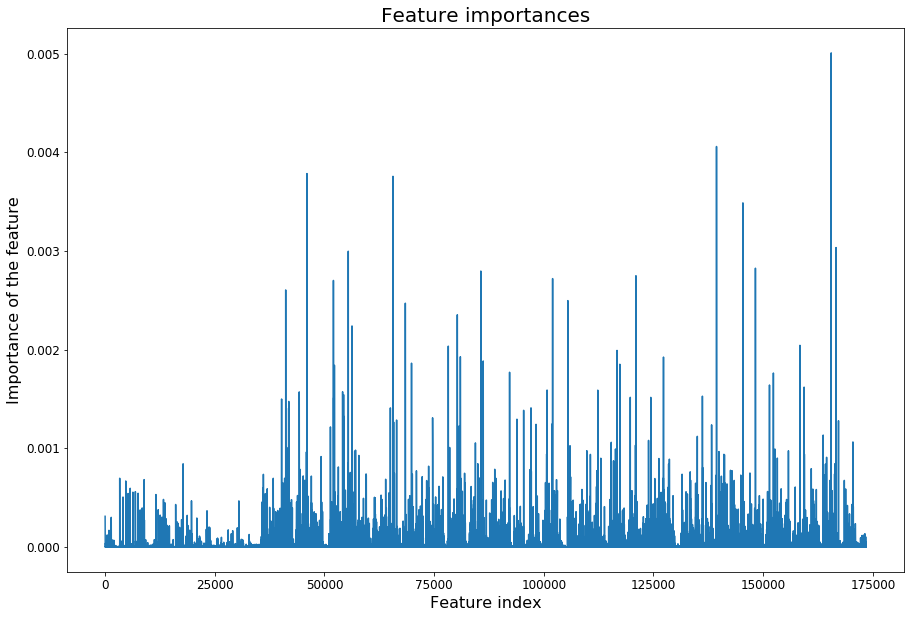

In [395]:
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(clf.feature_importances_)
plt.title("Feature importances", fontsize=20)
ax.set_xlabel("Feature index", fontsize=16)
ax.set_ylabel("Importance of the feature", fontsize=16)
ax.tick_params(labelsize=12);

From this raw graph, we can already see that a few features make up for most of the importance. Thus these features are the one that help categorizing the most a particular post.

We will now plot the cumulative importance of the features. Note that we used a logarithmic scale for the x-axis, this will help visualize the gain if we add an order of magnitude of features.

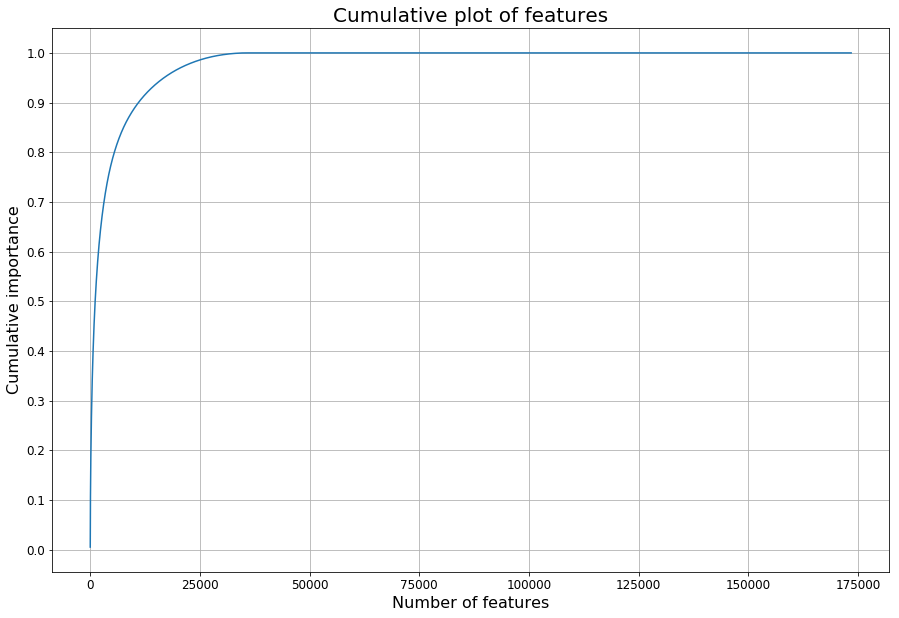

In [391]:
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(np.cumsum(sorted(clf.feature_importances_, reverse=True)))
ax.grid(True);
plt.title("Cumulative plot of features", fontsize=20)
ax.yaxis.set_ticks(np.arange(0, 1.1, 0.1))
ax.set_xlabel("Number of features", fontsize=16)
ax.set_ylabel("Cumulative importance", fontsize=16)
ax.tick_params(labelsize=12);

We see that the cumulative importance grows nearly linearily with the order of magnitude of added features. This means that the first few features are the most significant one. We'll proceed to print the names of these features to gain some insight on their nature. We sort the features by importance and print the top 20 words.

In [400]:
top20 = clf.feature_importances_.argsort()[-20:][::-1]
print(("\n".join(np.array(vectorizer.get_feature_names())[top20])))

windows
sale
bike
dod
space
writes
clipper
subject
hockey
organization
lines
car
article
mac
edu
god
com
university
game
nhl


The most important features are indeed terms that allow the model to efficiently disambiguate among categories. 
For instance if the term "windows" appears in a text, then most likely it'll be part of category "comp.os.ms-windows" or "comp.windows.x". "sale" is associated to category "misc.forsale, "bike" to category "rec.motorcycle" and so on.